<a href="https://colab.research.google.com/github/MinjuKim0217/Python-Machine-Learning-Book/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EA%B5%90%EA%B3%BC%EC%84%9C_15%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 머신 러닝 교과서 3판

# 15장 - 심층 합성곱 신경망으로 이미지 분류 (1/2)

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 합성곱 신경망의 구성 요소
    - CNN과 특성 계층 학습
    - 이산 합성곱 수행
        - 1차원 이산 합성곱 수행
        - 출력 특성 맵의 크기를 조절하기 위해 입력에 패딩하기
        - 합성곱 출력 크기 계산
        - 2D 이산 합성곱 수행
    - 서브샘플링
- 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성
    - 여러 개의 입력 또는 컬러 채널 다루기
    - 드롭아웃으로 신경망 규제
    - 분류를 위한 손실 함수
- 텐서플로를 사용하여 심층 합성곱 신경망 구현
    - 다층 CNN 구조
    - 데이터 적재와 전처리
    - 텐서플로 케라스 API를 사용해 CNN 구현하기
        - 케라스에서 CNN 층 설정하기
        - 케라스로 CNN 구성하기

In [40]:
from IPython.display import Image

## 합성곱 신경망의 구성 요소

### CNN과 특성 계층 학습

CNN과 같은 종류의 신경망은 원본 데이터에서 작업엥 가장 유용한 특성을 자동으로 학습할 수 있다. 이 때문에 CNN층을 특성 추출기로 생각하기도 함.

특정 종류의 다층 신경망과 특히 심층 합성곱 신경망은 각 층별로 저수준 특성을 연결하여 고수준 특성을 만듦으로서 소위 특성 계층을 구성하낟. 



In [41]:
Image(url='https://git.io/JL5O3', width=700)

CNN은 입력 이미지에 특성 맵을 만든다. 이 맵의 각 원소는 입력 이미지의 국부적인 픽셀 패치에서 유도된다. 

이런 국부적인 픽셀 패치를 **국부 수용장**이라고 말한다. CNN은 다음 두가지 이유 덕분에 이미지 관련 작업을 잘 한다. 

- **희소연결**: 특성 맵에 있는 하나의 원소는 작은 픽셀 패치 하나에만 연결된다. 
- **파라미터 공유**: 동일한 가중치가 입력 이미지의 모든 패치에 사용된다.



이 두 아이디어로 fully-connected MLP을 CNN으로 바꾸면 네트워크 가중치 개수가 극적으로 감소하고 중요 특징을 잡아내는 능력이 향상된다. 

---

CNN은 여러개의 합성곱과 풀일이라고도 하는 서브샘플링 층으로 이루어져 있는데 마지막에는 하나 이상의 완전 연결 층이 따라오게 된다.

풀링 층으로 알려진 서브 샘플링 층은 학습되는 파라미터가 없다. 즉, 풀링 층에는 가중치나 절편 유닛이 없다. 



### 이산 합성곱 수행

#### 1차원 이산 합성곱 수행

합성곱 공식에서의 덧셈을 올바르게 계산하기 위해선 x와 w가 0으로 채워져 있다고 가정해야 한다. 

또, 출력 벡터 y도 0으로 채워진 무한 크기가 되는데 이는 실제 상황에서는 유용하지 않기 때문에 유한한 개수의 0으로 x가 패딩된다. 

이 과정을 **제로 패딩** 혹은 **패딩** 이라고 한다. 

In [42]:
Image(url='https://git.io/JL5On', width=700)

하나가 반대 방향으로 인덱싱되는 계산은 패딩된 후 x또는 w벡터 중 하나를 뒤집어 계산하는것과 동일하다. 

패딩의 크기가 0일때 stride가 2일 때 나오는 y의 값은 (7,9, 8)이다. 

In [43]:
Image(url='https://git.io/JL5O8', width=700)

#### 출력 특성 맵의 크기를 조절하기 위해 입력에 패딩하기

패딩의 크기에 따라 특정 인덱스의 셀이 강조될수도 있다. 

실전에서 자주 사용하는 세 개의 패딩 방법은 풀 패딩, 세임 패딩, 밸리드 패딩이다. 

- Full padding: 파라미터 p를 p=m-1로 설정한다. 폴 패딩은 크기를 증가시키기 때문에 합성곱 신경망 구조에서는 거의 사용되지 않음
  - 입력보다 출력 크기를 증가시키므로 경계 부분의 영향을 최소화하는 것이 중요한 신호 처리에 보통 많이 사용된다. 
- Same padding: 출력 크기가 입력 벡터 x와 같아야 할 때 사용한다. 이때 패딩 파라미터 p는 입력과 출력 크기가 동일해야 하기 때문에 필터 크기에 따라 결정된다.
  - 합성곱 신경망에서 제일 많이 쓰인다 ; 벡터의 크기를 그대로 유지시키기 때문
  - 실전에서는 same padding으로 높이와 너비를 유지시키고 풀링에서 크기를 감소시킨다. 
- Valid padding: 패딩이 없는것을 말함
  - 신경망에 층이 추가될수록 점진적으로 텐서의 크기가 줄어들어 신경망의 성능을 나쁘게 만들수도 있다.

In [44]:
Image(url='https://git.io/JL5Ow', width=700)

#### 합성곱 출력 크기 계산

In [45]:
import tensorflow as tf
import numpy as np

print('텐서플로 버전:', tf.__version__)
print('넘파이 버전: ', np.__version__)

텐서플로 버전: 2.8.2
넘파이 버전:  1.21.6


In [46]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## 테스트:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d 구현:',
      conv1d(x, w, p=2, s=1))

print('넘파이 결과:',
      np.convolve(x, w, mode='same')) 

Conv1d 구현: [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과: [ 5 14 16 26 24 34 19 22]


#### 2D 이산 합성곱 수행

In [47]:
Image(url='https://git.io/JL5OP', width=700)

In [48]:
Image(url='https://git.io/JL5OD', width=600)

In [49]:
Image(url='https://git.io/JL5OS', width=800)

In [50]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d 구현:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('싸이파이 결과:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d 구현:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
싸이파이 결과:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### 서브샘플링

풀링의 장점:

- 최대 풀링은 지역 불변성을 만든다. 즉, 국부적인 작은 변화가 최대 풀링의 결과를 바꾸지 못한다.  입력 데이터에 있는 잡음에 좀 더 안정적인 특성을 생성한다. 
- 풀링은 특성 크기를 줄이므로 계산 효율성을 높인다. 또 특성 개수가 줄어들면 과대적합도 감소한다. 

전통적으로는 풀링은 겹치지 않는다고 가정한다. 풀링이 겹치지 않도록 수행되기 때문에 일반적으로 스트라이드 크기를 풀링 크기와 같게 설정한다. 

In [51]:
Image(url='https://git.io/JL5OH', width=700)

## 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성

### 여러 개의 입력 또는 컬러 채널 다루기

In [52]:
Image(url='https://git.io/JL5O5', width=800)

**팁: 이미지 파일 읽기**

In [53]:
# 코랩에서 실행할 경우 이미지를 먼저 다운로드합니다
!wget https://git.io/JL5Ob -O example-image.png

--2022-07-21 06:22:00--  https://git.io/JL5Ob
Resolving git.io (git.io)... 140.82.114.22
Connecting to git.io (git.io)|140.82.114.22|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image.png [following]
--2022-07-21 06:22:00--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image.png
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image.png [following]
--2022-07-21 06:22:01--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.

In [54]:
import tensorflow as tf


img_raw = tf.io.read_file('example-image.png')
img = tf.image.decode_image(img_raw)
print('이미지 크기:', img.shape)
print('채널 개수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)
print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 개수: 3
이미지 데이터 타입: <dtype: 'uint8'>
tf.Tensor(
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]], shape=(2, 2, 3), dtype=uint8)


In [55]:
import imageio


img = imageio.imread('example-image.png')
print('이미지 크기:', img.shape)
print('채널 개수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)
print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 개수: 3
이미지 데이터 타입: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


**노트: CNN 입력을 위한 흑백 이미지의 랭크**

In [56]:
# 코랩에서 실행할 경우 이미지를 먼저 다운로드합니다
!wget https://git.io/JL5Op -O example-image-gray.png

--2022-07-21 06:22:01--  https://git.io/JL5Op
Resolving git.io (git.io)... 140.82.114.22
Connecting to git.io (git.io)|140.82.114.22|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image-gray.png [following]
--2022-07-21 06:22:02--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image-gray.png
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image-gray.png [following]
--2022-07-21 06:22:02--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image-gray.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 1

In [57]:
img_raw = tf.io.read_file('example-image-gray.png')
img = tf.image.decode_image(img_raw)
tf.print('랭크:', tf.rank(img))
tf.print('크기:', img.shape)

랭크: 3
크기: TensorShape([252, 221, 1])


In [58]:
img = imageio.imread('example-image-gray.png')
tf.print('랭크:', tf.rank(img))
tf.print('크기:', img.shape)

img_reshaped = tf.reshape(img, (img.shape[0], img.shape[1], 1))
tf.print('새로운 크기:', img_reshaped.shape)

랭크: 2
크기: (252, 221)
새로운 크기: TensorShape([252, 221, 1])


### 드롭아웃으로 신경망 규제

In [59]:
Image(url='https://git.io/JL5Oh', width=700)

In [60]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

### 분류를 위한 손실 함수

 * **`BinaryCrossentropy()`**
   * `from_logits=False` 
   * `from_logits=True`

 * **`CategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`
   
 * **`SparseCategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`

In [61]:
Image(url='https://git.io/JL53f', width=800)

In [62]:
from distutils.version import LooseVersion as Version


####### 이진 크로스 엔트로피
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print(
    'BCE (확률): {:.4f}'.format(
    bce_probas(y_true=[1], y_pred=probas)),
    '(로짓): {:.4f}'.format(
    bce_logits(y_true=[1], y_pred=logits)))


####### 범주형 크로스 엔트로피
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

if Version(tf.__version__) >= '2.3.0':
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[[0, 0, 1]], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[[0, 0, 1]], y_pred=logits)))
else:
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[0, 0, 1], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[0, 0, 1], y_pred=logits)))

####### 희소 범주형 크로스 엔트로피
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

tf.print(
    'Sparse CCE (확률): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    '(로짓): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

BCE (확률): 0.3711 (로짓): 0.3711
CCE (확률): 0.5996 (로짓): 0.5996
Sparse CCE (확률): 0.5996 (로짓): 0.5996


## 텐서플로를 사용하여 심층 합성곱 신경망 구현

### 다층 CNN 구조

In [63]:
Image(url='https://git.io/JL53U', width=800)

### 데이터 적재와 전처리

In [64]:
import tensorflow_datasets as tfds
import pandas as pd

import matplotlib.pyplot as plt

In [65]:
## MNIST 데이터셋

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['test', 'train'])


In [66]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [67]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### 텐서플로 케라스 API를 사용해 CNN 구현하기

#### 케라스에서 CNN 층 설정하기

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters`
   * `kernel_size`
   * `strides`
   * `padding`
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`
   
   
 * **Dropout** `tf.keras.layers.Dropout2D`
   * `rate`

#### 케라스로 CNN 구성하기

In [68]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

In [69]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [70]:
model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [71]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [72]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              3212288   
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

In [74]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 16s 17ms/step - loss: 0.1374 - accuracy: 0.9571 - val_loss: 0.0480 - val_accuracy: 0.9856
Epoch 2/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0448 - accuracy: 0.9858 - val_loss: 0.0407 - val_accuracy: 0.9875
Epoch 3/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 0.0499 - val_accuracy: 0.9865
Epoch 4/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.0456 - val_accuracy: 0.9876
Epoch 5/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.0439 - val_accuracy: 0.9882
Epoch 6/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0389 - val_accuracy: 0.9905
Epoch 7/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0532 - val_accuracy: 0.9892
Epoc

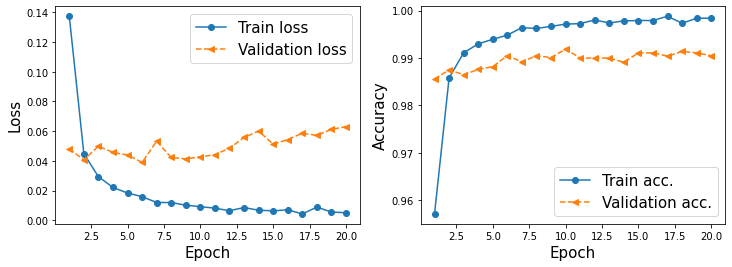

In [75]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('images/15_12.png', dpi=300)
plt.show()

In [76]:
test_results = model.evaluate(mnist_test.batch(20))
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 2s 4ms/step - loss: 0.0406 - accuracy: 0.9928

테스트 정확도 99.28%


TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


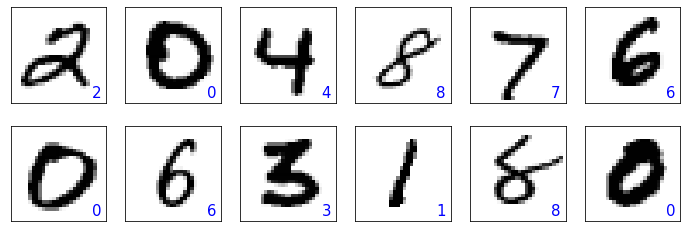

In [77]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('images/15_13.png', dpi=300)
plt.show()

In [78]:
import os

if not os.path.exists('models'):
    os.mkdir('models')


model.save('models/mnist-cnn.h5')